# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    # Create an array to store images, with shape (number of samples, 48, 48)
    image_array = np.zeros(shape=(len(data), 48, 48))
    # Convert 'emotion' column to an array of integers
    image_label = np.array(list(map(int, data['emotion'])))
     # Loop through each row in the dataframe
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
      # Create a figure with 2 rows and 5 columns of subplots
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
     # Loop through the first 10 images and labels
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        # Set the title of the subplot to show the label
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

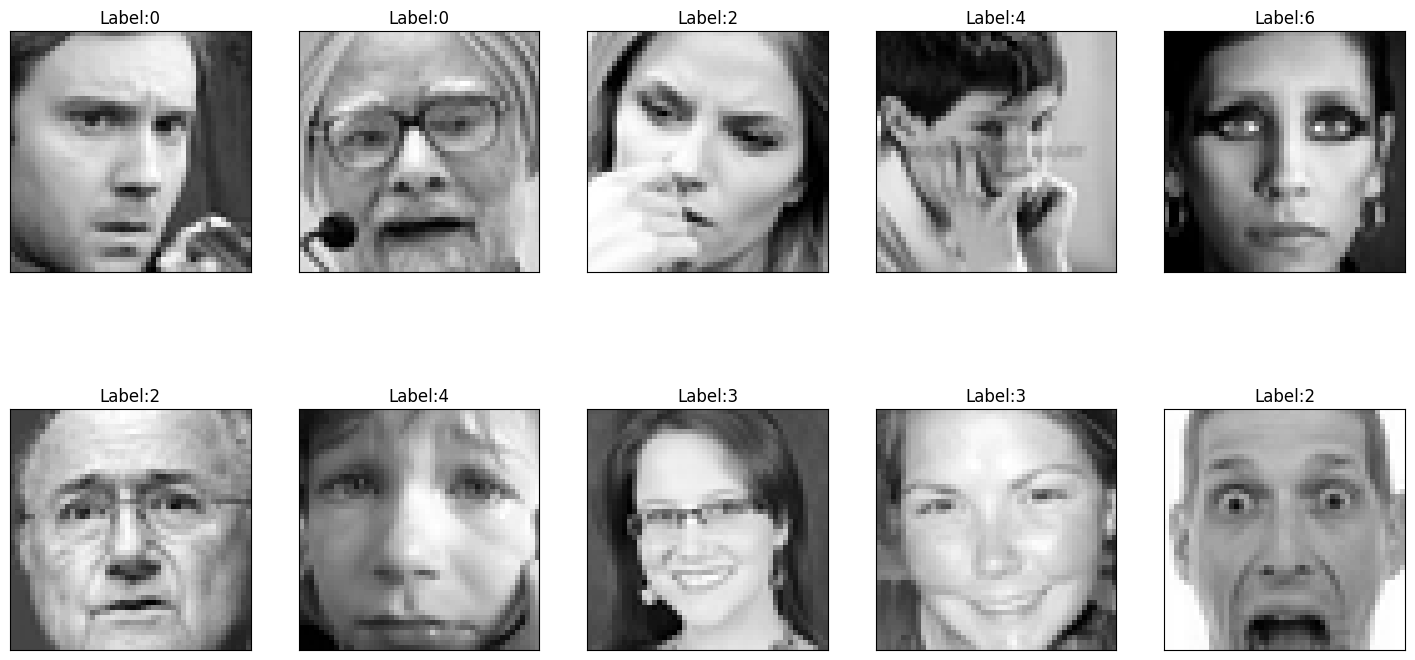

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)

In [ ]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape

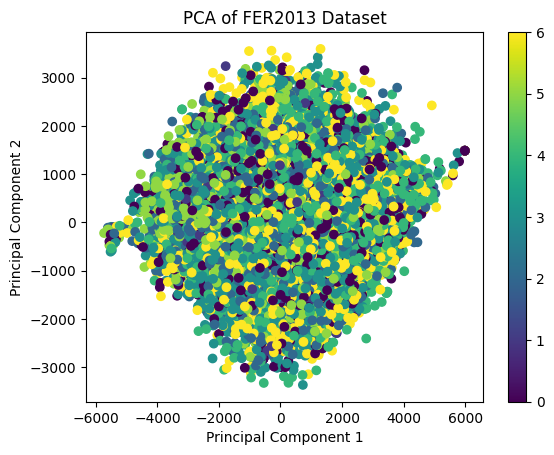

In [ ]:
# Reshape images for PCA
images_flattened = images.reshape(len(images), -1)
# Perform PCA on the flattened images
images_pca = pca.fit_transform(images_flattened)
# Visualize the data
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.title('PCA of FER2013 Dataset')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [ ]:
## determine the optimal number of PCs here
## pca.explained_variance_()

In [ ]:
# Apply PCA with all components
pca_full = PCA().fit(images_flattened)

# Calculate explained variance
explained_variance = pca_full.explained_variance_ratio_

# Plot explained variance
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# Select the number of components that explain at least 95% of the variance
optimal_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f'Optimal number of components: {optimal_components}')

- Explain your selection process: "We choose the optimal number of principal components because we need to select the smallest number of components that still capture most of the information in our data. A common approach is to pick enough components to cover about 95% of the total data variance. It's like finding the right balance in a recipe – using just enough ingredients to get the full flavor without making it too complicated."

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

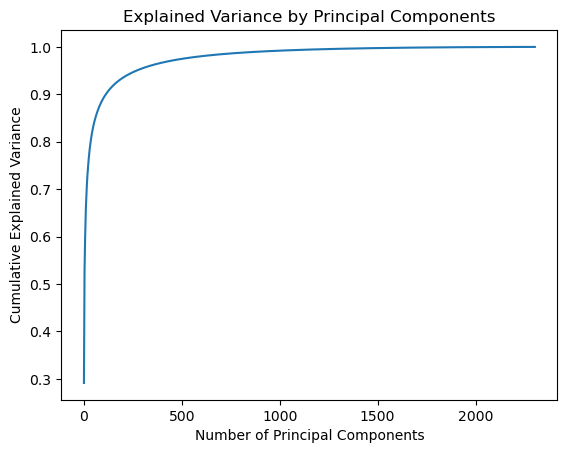

Optimal number of components: 269


In [ ]:
# Perform PCA to determine the optimal number of components
pca_full = PCA().fit(X_train_scaled)
explained_variance = pca_full.explained_variance_ratio_

# Plot explained variance
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components') # Label for the x-axis
plt.ylabel('Cumulative Explained Variance') # Label for the y-axis
plt.title('Explained Variance by Principal Components') # Title of the plot
plt.show()

# Select the number of components that explain at least 95% of the variance
optimal_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f'Optimal number of components: {optimal_components}')

In [ ]:
optimal_components = 269  # Based on the provided plot

# Transform data using PCA with optimal number of components
# Fit PCA on the training data with the optimal number of components
pca_optimal = PCA(n_components=optimal_components).fit(X_train_scaled)

# Transform the training, validation, and test data using the fitted PCA
X_train_pca = pca_optimal.transform(X_train_scaled)
X_val_pca = pca_optimal.transform(X_val_scaled)
X_test_pca = pca_optimal.transform(X_test_scaled)

In [ ]:
# Define classifiers
classifiers = {
    'Logistic Regression (lbfgs)': LogisticRegression(max_iter=5000, solver='lbfgs'),  # Logistic Regression using 'lbfgs' solver
    'Logistic Regression (saga)': LogisticRegression(max_iter=5000, solver='saga'),    # Logistic Regression using 'saga' solver
    'Logistic Regression (liblinear)': LogisticRegression(max_iter=5000, solver='liblinear'),  # Logistic Regression using 'liblinear' solver
    'SVM': SVC(),  # Support Vector Machine
    'Random Forest': RandomForestClassifier(),  # Random Forest Classifier
    'MLP': MLPClassifier(max_iter=1000)  # Multi-Layer Perceptron with 1000 max iterations
}

# Fit and evaluate classifiers on original scaled data
for name, clf in classifiers.items():
    # Train the classifier on the original scaled training data
    clf.fit(X_train_scaled, y_train)
    # Predict on the validation data
    y_pred = clf.predict(X_val_scaled)
    # Print performance metrics
    print(f'Performance of {name} on original scaled data:')
    print(classification_report(y_val, y_pred))

# Fit and evaluate classifiers on PCA-transformed data
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_val_pca)
    print(f'Performance of {name} on PCA-transformed data:')
    print(classification_report(y_val, y_pred))

Performance of Logistic Regression (lbfgs) on original scaled data:
              precision    recall  f1-score   support

           0       0.24      0.19      0.21       803
           1       0.10      0.17      0.13        82
           2       0.23      0.19      0.21       804
           3       0.46      0.51      0.48      1513
           4       0.25      0.25      0.25       938
           5       0.43      0.45      0.44       665
           6       0.26      0.28      0.27       937

    accuracy                           0.33      5742
   macro avg       0.28      0.29      0.28      5742
weighted avg       0.32      0.33      0.32      5742



In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'Logistic Regression (lbfgs)': {'C': [0.1, 1, 10]},
    'Logistic Regression (saga)': {'C': [0.1, 1, 10]},
    'Logistic Regression (liblinear)': {'C': [0.1, 1, 10]},
    'SVM': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [10, 50, 100]},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}
}

# Dictionary to store best estimators
best_estimators = {}

# Iterate over each classifier and its corresponding parameter grid
for name, clf in classifiers.items():
    # Perform grid search using 3-fold cross-validation
    grid_search = GridSearchCV(clf, param_grid[name], cv=3, scoring='accuracy')

    # Fit the grid search to find the best estimator
    grid_search.fit(X_train_scaled, y_train)

    # Save the best estimator found by grid search
    best_estimators[name] = grid_search.best_estimator_

    # Print the best parameters found for the current classifier
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Evaluate best estimators on validation data
# Iterate over each best estimator
for name, clf in best_estimators.items():
    # Predict labels for the validation data
    y_pred = clf.predict(X_val_scaled)

    # Print the performance metrics for the current classifier
    print(f'Performance of {name} on validation data after tuning:')
    print(classification_report(y_val, y_pred))


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate each best estimator on the test data
for name, clf in best_estimators.items():
    # Predict labels for the test data
    y_pred = clf.predict(X_test_scaled)

    # Print the performance metrics for the current classifier
    print(f'Performance of {name} on test data:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')  # Print accuracy score
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')  # Print precision score
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')  # Print recall score
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")}')  # Print F1-score

    # Print the confusion matrix for the current classifier
    print(confusion_matrix(y_test, y_pred))

    # Print the detailed classification report for the current classifier
    print(classification_report(y_test, y_pred))


Explan code

1// Imports and Setup

2// Data Parsing: (def parse_data...
                    return image_array, image_label)

3// Image Visualization: (def show_img...
                    axarr[idx].set_title("Label:{}".format(label)) )

4// Loading and Parsing Dataset: (df = pd.read_csv...
                                     = parse_data(df))       

5// Showing Image: (show_img(images, labels) )

6// Principal Component Analysis (PCA): (from sklearn.decomposition...
                                         plt.colorbar()
                                         plt.show())

7// Splitting the Data: (from sklearn.model_selection...
                          test_size=0.2, random_state=42)

8// Data Scaling: (from sklearn.preprocessing...
                    X_test_scaled = scaler.transform(X_test))

9// Classification and Hyperparameter Tuning: (from sklearn.model_selection import GridSearchCV...
                                        print(f'Best parameters for {name}: {grid_search.best_params_}'))         
                                        
10// Validation Performance:(for name, clf in best_estimators.items()...
 print(classification_report(y_test, y_pred)))


Interest Finding
- GridSearchCV giúp ta tự động tìm kiếm các tham số tối ưu mà không cần phải thử nghiệm thủ công từng giá trị một. Điều này tiết kiệm thời gian và đảm bảo rằng ta không bỏ lỡ các thiết lập tham số tốt.
- Biểu đồ scatter từ PCA cho thấy cách các dữ liệu được phân phối trong không gian 2D. Bạn có thể quan sát các nhóm hoặc mẫu trong dữ liệu, giúp bạn nhận ra các cụm hoặc xu hướng trong tập dữ liệu.
- Mình có thể thử nghiệm với các kỹ thuật giảm chiều khác như T-SNE hoặc UMAP, thường được sử dụng để trực quan hóa dữ liệu phức tạp hơn trong không gian 2D hoặc 3D.
- Sử dụng các kỹ thuật tinh chỉnh tham số khác như RandomizedSearchCV hoặc Bayesian Optimization để tăng tốc quá trình tìm kiếm tham số tối ưu.